# Purpose:



## Imports:

In [1]:
# %matplotlib inline
%matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import ggplot as gp

import mpld3
# mpld3.enable_notebook()

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 60)
# import tables as h5

import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.formula import api as smform

import munch

import pybedtools as pbt

import pymc as mc

from shapely.geometry import LineString

import networkx as nx

import tabulate
tbl = tabulate.tabulate


from spartan.utils.genome_specific.GfusI1 import GfusI1_0
from spartan.utils.fastas import ParseFastA

from spartan.utils.annotations.ensembl.gff3 import parse_gff3
from spartan.utils.annotations.ensembl.gff3 import parse_gff3_attributes
from spartan.utils.files import tableFile2namedTuple

from gs_ddRAD2015.scripts import ld_figures as ldfigs


Using matplotlib backend: TkAgg


/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# set figure characteristics

# size
sns.set_context("poster")

# Grid style
sns.set_style("whitegrid")

# colors
sns.set_palette(sns.hls_palette(n_colors=5, h=0.59, l=0.4, s=0.75))

## File paths:

In [3]:
# define paths to files
# out_dir = "/home/gus/MEGAsync/projects/ddRAD_phase2/repos/ddRAD_phase2/scratch/gs_2015_ld/OT"
# out_dir = "/home/gus/MEGAsync/projects/ddRAD_phase2/repos/ddRAD_phase2/scratch/gs_2015_ld/MS"
# out_dir = "/home/gus/MEGAsync/projects/ddRAD_phase2/repos/ddRAD_phase2/scratch/gs_2015_ld/NB"
out_dir = "/home/gus/MEGAsync/projects/ddRAD_phase2/repos/ddRAD_phase2/scratch/gs_2015_ld/KG"

## Functional annatation (Argot2)
fanno = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/annotations/functional/GfusI1.1_pre/argot2_out/argot_functional_annotations_ts150.h5"

# gene models
btools_gene_models_gff3 = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/annotations/Glossina-fuscipes-IAEA_BASEFEATURES_GfusI1.1.gff3"

# Andrea's Genes


# Some bedtools helper funcs

In [4]:
def bed3_v_gff3_window_by_gff3_ID(bedtools_window_out):
    """
    Returns dictionary-based retrieval object for Bedtools result from 3-field BED format records vs
    GFF3 format records data grouped by the GFF3 features.
    """
    headers = ["bed3_seq",
               "bed3_start",
               "bed3_end",
               "gff3_seq",
               "gff3_source",
               "gff3_type",
               "gff3_start",
               "gff3_end",
               "gff3_score",
               "gff3_strand",
               "gff3_phase",
               "gff3_attributes",]
    
    table = tableFile2namedTuple(bedtools_window_out, 
                                 sep='\t', 
                                 headers=headers)
    
    Tree = lambda: defaultdict(Tree)
    data = Tree()
    
    for row in table:
        gff3_rec = parse_gff3_attributes(row.gff3_attributes)['ID']

        data[gff3_rec]['info'].setdefault('seq', row.gff3_seq)
        data[gff3_rec]['info'].setdefault('source', row.gff3_source)
        data[gff3_rec]['info'].setdefault('type', row.gff3_type)
        data[gff3_rec]['info'].setdefault('start', row.gff3_start)
        data[gff3_rec]['info'].setdefault('end', row.gff3_end)
        data[gff3_rec]['info'].setdefault('score', row.gff3_score)
        data[gff3_rec]['info'].setdefault('strand', row.gff3_strand)
        data[gff3_rec]['info'].setdefault('phase', row.gff3_phase)
        data[gff3_rec]['info'].setdefault('attributes', row.gff3_attributes)

        bed3_hit = dict(seq = row.bed3_seq, 
                        start = row.bed3_start,
                        end = row.bed3_end)

        try:
            data[gff3_rec]['bed3_hits'].append(bed3_hit)

        except AttributeError:
            data[gff3_rec]['bed3_hits'] = []
            data[gff3_rec]['bed3_hits'].append(bed3_hit)

    return munch.munchify(data)

def snp_vs_gff_to_DF(bedtools_out):
    if bedtools_out is None:
        return None
    headers = ["bed3_seq",
               "bed3_start",
               "bed3_end",
               "gff3_seq",
               "gff3_source",
               "gff3_type",
               "gff3_start",
               "gff3_end",
               "gff3_score",
               "gff3_strand",
               "gff3_phase",
               "gff3_attributes",]
    df = pd.read_csv(bedtools_out.fn, sep='\t', names=headers)
    
    gene_id = lambda x: parse_gff3_attributes(x)['ID']
    
    df['gff3_rec'] = df.gff3_attributes.apply(gene_id)
    
    return df

## Loading files

In [5]:
argot2 = pd.read_hdf(path_or_buf=fanno, key='dataframe')
argot2['gene_id'] = argot2.Sequence.apply(lambda x: x[:-3])
argot2_200 = argot2[argot2['Total Score'] >= 200]
argot2 = argot2.drop_duplicates()
argot2.head()

,Sequence,Aspect,GO ID,Name,Total Score,Internal Confidence,Information Content,gene_id
0,GFUI034947-PA,P,GO:0006508,proteolysis,270.313447,0.496543,8.247696,GFUI034947
1,GFUI035874-PA,F,GO:0005515,protein binding,529.038456,0.500000,5.471582,GFUI035874
2,GFUI033625-PA,P,GO:0005980,glycogen catabolic process,307.758251,0.284597,13.424450,GFUI033625
3,GFUI033625-PA,F,GO:0004134,4-alpha-glucanotransferase activity,159.513252,0.177063,10.153643,GFUI033625
4,GFUI033625-PA,F,GO:0004135,"amylo-alpha-1,6-glucosidase activity",184.352303,0.177063,11.734746,GFUI033625


In [6]:
gene_mods = pbt.BedTool(btools_gene_models_gff3).filter(lambda x: x[2] == 'gene').sort()#".saveas()

In [7]:
figs = ldfigs.Figures(out_dir=out_dir, formats='png')

In [8]:
figs.load_data_tables()


ld_figures: loading data_tables.




In [9]:
tables = munch.Munch(figs.d)
tables.keys()

['ld',
 'd_bins',
 'contig_info',
 'd_bin_v_others_melt',
 'len_contigs_per_bin',
 'd_bin_v_others',
 'contigs_per_bin',
 'mean_bin_r2_all',
 'sp_contigs',
 'ld_contig']

In [10]:
ld = tables.ld
ld.head()

,Unnamed: 0,CHR_A,BP_A,BP_B,N_INDV,R2,BP_DELTA,distance_bin,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded
0,0,Scaffold0,13388,23408,3,NaN,10020,10000,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1,Scaffold0,13388,23418,3,NaN,10030,10000,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2,Scaffold0,13388,23421,3,NaN,10033,10000,NaN,NaN,NaN,NaN,NaN,NaN,False
3,3,Scaffold0,13388,23431,3,NaN,10043,10000,NaN,NaN,NaN,NaN,NaN,NaN,False
4,4,Scaffold0,13388,30544,3,NaN,17156,17150,NaN,NaN,NaN,NaN,NaN,NaN,False


In [11]:
ld_contig = tables.ld_contig
ld_contig.head()

,Unnamed: 0,CHR_A,BP_A,BP_B,N_INDV,R2,BP_DELTA,distance_bin,R2_scaled_for_B,alpha_param,beta_param,cdf,one_minus_cdf,one_minus_cdf_BH,MAP_succeeded,kk_name,scaf_name,length
0,0,Scaffold0,13388,23408,3,NaN,10020,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
1,1,Scaffold0,13388,23418,3,NaN,10030,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
2,2,Scaffold0,13388,23421,3,NaN,10033,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
3,3,Scaffold0,13388,23431,3,NaN,10043,10000,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503
4,4,Scaffold0,13388,30544,3,NaN,17156,17150,NaN,NaN,NaN,NaN,NaN,NaN,False,KK351785.1,Scaffold0,3329503


In [12]:
def get_halfing_coords(xs, ys, num, tolerance):
    xs_return = []
    ys_return = []
    
    halfing_values = get_n_halfing_values(val=ys[0],n=num)[1:]
    
    for value in halfing_values:
        indexes_close_to_yi = get_indexes_close_to_yi(ys=ys, value=value, tolerance=tolerance)
        middle_item = get_first_item(indexes=indexes_close_to_yi)
        if middle_item is None:
            print 'None'
        else:
            # print indexes_close_to_yi
            # print xs[middle_item]
            # print ys[middle_item]
            xs_return.append(xs[middle_item])
            ys_return.append(ys[middle_item])
    
    return xs_return,ys_return
    
def get_indexes_close_to_yi(ys, value, tolerance):
    ilist = []
    for i,y in enumerate(ys):
        if abs(value-y) <= tolerance:
            ilist.append(i)
    return ilist
    
def get_n_halfing_values(val, n):
    rvalues = []
    c_val = val
    for i in range(n+1):
        c_val = c_val/2.0
        rvalues.append(c_val)
    return rvalues
        
def get_middle_item(indexes):
    if len(indexes) == 0:
        return None
    return indexes[int(len(indexes)/2)]

def get_first_item(indexes):
    if len(indexes) == 0:
        return None
    return indexes[0]

# Distance bt snp-pair vs R^2 all:

### Pivot for distance_bin stats

In [13]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [14]:
ld_pv_distbin_by_mean_R2_cdfs = pd.pivot_table(data=ld, 
                                               values=["R2","one_minus_cdf_BH","one_minus_cdf"], 
                                               index="distance_bin", 
                                               columns=None, 
                                               aggfunc=np.mean, 
                                               fill_value=None, margins=False, dropna=True).reset_index()

ld_pv_distbin_by_mean_R2_cdfs.head()

,distance_bin,R2,one_minus_cdf,one_minus_cdf_BH
0,0,0.932564,0.395043,NaN
1,50,0.883961,0.411303,NaN
2,100,0.891854,0.412130,NaN
3,150,0.855263,0.431693,NaN
4,200,0.882716,0.411702,NaN


In [15]:
ld_pv_count_distbin = pd.pivot_table(data=ld,
                                     values="R2", 
                                     index="distance_bin", 
                                     columns=None, 
                                     aggfunc=len, 
                                     fill_value=None, margins=False, dropna=True).reset_index()


ld_pv_count_distbin.head()

,distance_bin,R2
0,0,36566
1,50,4274
2,100,2010
3,150,1204
4,200,1159


In [16]:
ld_pv_distbin_by_mean_R2_cdfs = ld_pv_distbin_by_mean_R2_cdfs.merge(right=ld_pv_count_distbin, 
                                    how='inner', on='distance_bin', 
                                    left_on=None, right_on=None,
                                    suffixes=('', '_count'),
                                    copy=True)
ld_pv_distbin_by_mean_R2_cdfs.head()
new_column_names = ld_pv_distbin_by_mean_R2_cdfs.columns.values
new_column_names[-1] = 'SNP-pairs'
ld_pv_distbin_by_mean_R2_cdfs.columns = new_column_names
ld_pv_distbin_by_mean_R2_cdfs.head()

,distance_bin,R2,one_minus_cdf,one_minus_cdf_BH,SNP-pairs
0,0,0.932564,0.395043,NaN,36566
1,50,0.883961,0.411303,NaN,4274
2,100,0.891854,0.412130,NaN,2010
3,150,0.855263,0.431693,NaN,1204
4,200,0.882716,0.411702,NaN,1159


In [17]:
ld_pv_distbin_by_mean_R2_cdfs_melt = pd.melt(ld_pv_distbin_by_mean_R2_cdfs, id_vars=['distance_bin'])
ld_pv_distbin_by_mean_R2_cdfs_melt.tail()

,distance_bin,variable,value
209979,3274650,SNP-pairs,1
209980,3274800,SNP-pairs,1
209981,3274850,SNP-pairs,1
209982,3275650,SNP-pairs,1
209983,3277750,SNP-pairs,2


In [18]:
d_bin_v_others_melt = figs.d.d_bin_v_others_melt

In [19]:
# mpld3.enable_notebook()
# mpld3.disable_notebook()

In [20]:
# pal = sns.choose_colorbrewer_palette("s")

# pal = sns.husl_palette(n_colors=4, h=0.6, s=0.9, l=0.65)
# pal = sns.hls_palette(n_colors=5, h=0.59, l=0.4, s=0.75)
# sns.palplot(pal)

# pal = sns.choose_cubehelix_palette()

In [21]:
sns.regplot

<function seaborn.linearmodels.regplot>

In [22]:
# # sns.set_palette(pal)

# melted_r2 = ld_pv_distbin_by_mean_R2_cdfs_melt.query("variable == 'R2'").query("0 <= distance_bin <= 500000")

# d = melted_r2.distance_bin

# r2 = melted_r2.value
# r2_95centile = r2.quantile(.95)

# rgplt = sns.regplot(d, r2, data=None, x_estimator=None, x_bins=None, x_ci=95, 
#             scatter=True, fit_reg=False, ci=95, n_boot=10000, 
#             )

# # plt.plot(d,
# #          movingaverage(interval=r2, window_size=6),
# #          color='coral', alpha=0.3);

# # lowess regression
# delta = 0.01 * len(d)
# r2_lowess = lowess(r2,d,frac=0.02, it=0, delta=delta)
# r2_half = r2.max()/2.


# centile_line = [[0,r2_95centile],[r2_lowess[-1][0],r2_95centile]]
# halfing_line = [[0,r2_half],[r2_lowess[-1][0],r2_half]]

# halfing_geo = LineString(halfing_line)
# centile_geo = LineString(centile_line)
# lowess_geo = LineString(r2_lowess)

# isect_c = centile_geo.intersection(lowess_geo)
# isect_h = halfing_geo.intersection(lowess_geo)

# isect_c_x,isect_c_y = int(round(isect_c.x)), isect_c.y
# isect_h_x,isect_h_y = int(round(isect_h.x)), isect_h.y

# plt.plot(d,
#          r2_lowess[:,1],
#          alpha=1,
#          label="Lowess regression line");

# plt.plot([x[0] for x in halfing_line],
#          [y[1] for y in halfing_line],  
#          label=u"Half of maximum LD ({isect} bp)".format(isect=isect_h_x),
#          alpha=1
#         );

# plt.plot([x[0] for x in centile_line],
#          [y[1] for y in centile_line], 
#          label="95th percentile of mean bin-wise LD ({isect} bp)".format(isect=isect_c_x),
#          alpha=1
#         );




# # plt.plot(0,0,label="test3",alpha=0)

# # plt.scatter(x=xs_hlf, y=ys_hlf, 
# #             s=200, c=u'k', marker=u'x', 
# #             alpha=None, linewidths=2);

# plt.xlabel(r"Distance between SNP-pairs (bp)");
# plt.ylabel(r"Mean bin-wise LD ($r^2$)");



# plt.legend()

# # print "xs_hlf, ys_hlf: ",xs_hlf, ys_hlf 



In [24]:
# sns.set_palette(pal)

filtered_by_bin = ld_pv_distbin_by_mean_R2_cdfs.query("0 <= distance_bin <= 500000")

snppairs = filtered_by_bin["SNP-pairs"]
d = filtered_by_bin.distance_bin
r2 = filtered_by_bin.R2
r2_95centile = r2.quantile(.95)

scat = plt.scatter(x=d, y=r2, s=20, c=np.log2(snppairs), 
                   marker=u'o', cmap="cubehelix_r", 
                   norm=None, vmin=None, vmax=None, 
                   alpha=1, linewidths=0, verts=None, hold=None);
plt.colorbar(scat, label=r"log$_{2}$(pairs per bin)");


# lowess regression
delta = 0.01 * len(d)
r2_lowess = lowess(r2,d,frac=0.02, it=0, delta=delta)
r2_half = r2.max()/2.


point_2_line = [[0,0.2],[r2_lowess[-1][0],0.2]]
halfing_line = [[0,r2_half],[r2_lowess[-1][0],r2_half]]

halfing_geo = LineString(halfing_line)
point_2_geo = LineString(point_2_line)
lowess_geo = LineString(r2_lowess)

isect_2 = point_2_geo.intersection(lowess_geo)
isect_h = halfing_geo.intersection(lowess_geo)

isect_2_x,isect_2_y = int(round(isect_2.x)), isect_2.y
isect_h_x,isect_h_y = int(round(isect_h.x)), isect_h.y

plt.plot(d,
         r2_lowess[:,1],
         alpha=1,
         label="Lowess regression line");

plt.plot([x[0] for x in halfing_line],
         [y[1] for y in halfing_line],  
         label=u"Half of maximum LD ({isect} bp)".format(isect=isect_h_x),
         alpha=1
        );

plt.plot([x[0] for x in point_2_line],
         [y[1] for y in point_2_line], 
         label="Crosses $r^2 = 0.2$ ({isect} bp)".format(isect=isect_2_x),
         alpha=1
        );




# plt.plot(0,0,label="test3",alpha=0)

# plt.scatter(x=xs_hlf, y=ys_hlf, 
#             s=200, c=u'k', marker=u'x', 
#             alpha=None, linewidths=2);

plt.xlabel(r"Distance between SNP-pairs (bp)");
plt.ylabel(r"Mean bin-wise LD ($r^2$)");
plt.title("Site KG")


plt.legend();

# print "xs_hlf, ys_hlf: ",xs_hlf, ys_hlf 



AttributeError: 'GeometryCollection' object has no attribute 'x'

In [24]:
r2.max()

0.54458602240766685

In [25]:
r2_half

0.27229301120383342

In [26]:
r2_95centile

0.19126966377874197

In [27]:
melted_r2.head()

,distance_bin,variable,value
0,0,R2,0.544586
1,50,R2,0.419256
2,100,R2,0.373737
3,150,R2,0.354970
4,200,R2,0.367123


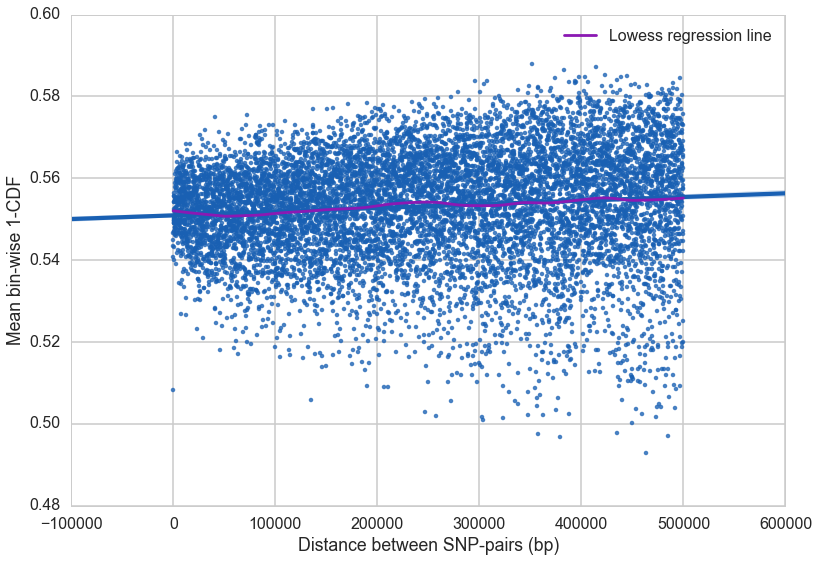

In [28]:
# sns.set_palette(pal)

melted_one_minus_cdf = ld_pv_distbin_by_mean_R2_cdfs_melt.query("variable == 'one_minus_cdf'").query("0 <= distance_bin <= 500000")

d = melted_one_minus_cdf.distance_bin

one_minus_cdf = melted_one_minus_cdf.value

rgplt = sns.regplot(d, one_minus_cdf, data=None, x_estimator=None, x_bins=None, x_ci=95, 
            scatter=True, fit_reg=True, ci=95, n_boot=10000)

# plt.plot(d,
#          movingaverage(interval=one_minus_cdf, window_size=6),
#          color='coral', alpha=0.3);

# lowess regression
delta = 0.01 * len(d)
one_minus_cdf_lowess = lowess(one_minus_cdf,d,frac=0.2, it=0, delta=delta)

plt.plot(d,
         one_minus_cdf_lowess[:,1],
         alpha=1,
         label="Lowess regression line");



plt.xlabel(r"Distance between SNP-pairs (bp)");
plt.ylabel(r"Mean bin-wise 1-CDF");



plt.legend()

# print "xs_hlf, ys_hlf: ",xs_hlf, ys_hlf 



# Describe number of SNP-pairs that pass bin filtering and distance pattern (if any) 

In [29]:
ld_filtered = ld.query("one_minus_cdf_BH <= 0.01")
ld_pv_filtered = ld_pv_distbin_by_mean_R2_cdfs.query("one_minus_cdf_BH <= 0.01")

In [30]:
len(ld)

6454294

In [31]:
# len(ld.drop_duplicates())

In [32]:
len(ld_filtered)

0

In [33]:
100.*len(ld_filtered)/len(ld)

0.0

/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


ZeroDivisionError: float division by zero

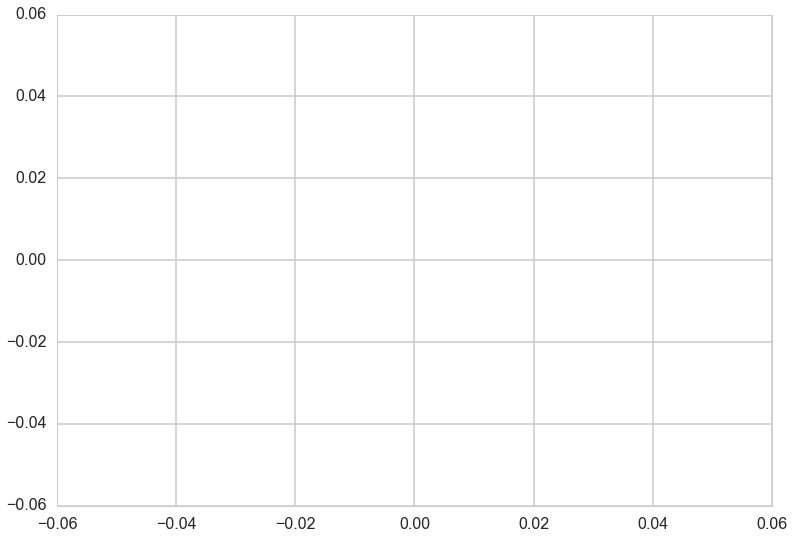

In [34]:
sns.distplot(ld_filtered.R2.dropna(), kde=0);

In [ ]:
ld_filtered.head()

In [ ]:
# mod = smform.ols("R2 ~ CHR_A", ld_filtered)
# res_R2_by_CHR_A = mod.fit()

In [ ]:
# sns.distplot(res_R2_by_CHR_A.params[1:], kde=0)

In [ ]:
sns.jointplot(ld_filtered.BP_DELTA, ld_filtered.R2, kind='hex')

-------------------

# Examine whether any of Andrea's  genes are in the filtered set

In [ ]:
## SNPs of interest BED  ----------------------------------------------------------

#### from folder: 2015-03-17_env_selection
Selected_PopPairwiseMSNB_Environm_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-03-17_env_selection/Selected_PopPairwiseMSNB_Environm.bed"
Selected_PopPairwiseMSOT_Environm_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-03-17_env_selection/Selected_PopPairwiseMSOT_Environm.bed"
Selected_PopPairwiseMSvsNBOT_Environm_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-03-17_env_selection/Selected_PopPairwiseMSvsNBOT_Environm.bed"

#### from folder: 2015-02-26_bayescan_tables and 2015-07-23_overlap_infection
Top10_PopPairwiseOverlap_Infection_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-07-23_overlap_infection/Top10_corrected_PopPairwiseOverlap_Infection2015.bed"
Top10_PopPairwiseOverlap_Environm_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-02-26_bayescan_tables/Top10_PopPairwiseOverlap_Environm.bed"
Top05_InfectionOverall_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-02-26_bayescan_tables/Top05_InfectionOverall.bed"
Top05_PopPairwiseOverlap_Environm_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-02-26_bayescan_tables/Top05_PopPairwiseOverlap_Environm.bed"
Top05_PopPairwiseOverlap_Infection_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-02-26_bayescan_tables/Top05_PopPairwiseOverlap_Infection.bed"
Top10_InfectionOverall_bed = "/home/gus/Documents/YalePostDoc/project_stuff/g_f_fucipes_uganda/ddrad58/data_from_andrea/2015-02-26_bayescan_tables/Top10_InfectionOverall.bed"

In [ ]:
# read bed files into dataframes and name the columns
bed_headers = ['seq','start','end']

Selected_PopPairwiseMSNB_Environm_df = pd.read_csv(Selected_PopPairwiseMSNB_Environm_bed, header=None, names=bed_headers, sep='\t')
Selected_PopPairwiseMSOT_Environm_df = pd.read_csv(Selected_PopPairwiseMSOT_Environm_bed, header=None, names=bed_headers, sep='\t')
Selected_PopPairwiseMSvsNBOT_Environm_df = pd.read_csv(Selected_PopPairwiseMSvsNBOT_Environm_bed, header=None, names=bed_headers, sep='\t')
Top10_PopPairwiseOverlap_Infection_df = pd.read_csv(Top10_PopPairwiseOverlap_Infection_bed, header=None, names=bed_headers, sep='\t')
Top10_PopPairwiseOverlap_Environm_df = pd.read_csv(Top10_PopPairwiseOverlap_Environm_bed, header=None, names=bed_headers, sep='\t')
Top05_InfectionOverall_df = pd.read_csv(Top05_InfectionOverall_bed, header=None, names=bed_headers, sep='\t')
Top05_PopPairwiseOverlap_Environm_df = pd.read_csv(Top05_PopPairwiseOverlap_Environm_bed, header=None, names=bed_headers, sep='\t')
Top05_PopPairwiseOverlap_Infection_df = pd.read_csv(Top05_PopPairwiseOverlap_Infection_bed, header=None, names=bed_headers, sep='\t')
Top10_InfectionOverall_df = pd.read_csv(Top10_InfectionOverall_bed, header=None, names=bed_headers, sep='\t')

snps_interest = munch.Munch(dict(Selected_PopPairwiseMSNB_Environm=Selected_PopPairwiseMSNB_Environm_df,
    Selected_PopPairwiseMSOT_Environm=Selected_PopPairwiseMSOT_Environm_df,
    Selected_PopPairwiseMSvsNBOT_Environm=Selected_PopPairwiseMSvsNBOT_Environm_df,
    Top10_PopPairwiseOverlap_Infection=Top10_PopPairwiseOverlap_Infection_df,
    Top10_PopPairwiseOverlap_Environm=Top10_PopPairwiseOverlap_Environm_df,
    Top05_InfectionOverall=Top05_InfectionOverall_df,
    Top05_PopPairwiseOverlap_Environm=Top05_PopPairwiseOverlap_Environm_df,
    Top05_PopPairwiseOverlap_Infection=Top05_PopPairwiseOverlap_Infection_df,
    Top10_InfectionOverall=Top10_InfectionOverall_df))

In [ ]:
len(snps_interest.Top10_PopPairwiseOverlap_Infection)

In [ ]:
snps_interest.Top10_PopPairwiseOverlap_Infection

In [ ]:
def join_SNP_pairs_and_SNPs_of_interest(dfp, dfi):
    
    dfp = dfp[["CHR_A","BP_A","BP_B","N_INDV","R2","BP_DELTA","distance_bin","one_minus_cdf","one_minus_cdf_BH"]]

    join1 = pd.merge(left=dfp, right=dfi, 
                     how='right', on=None, 
                     left_on=["CHR_A","BP_A"], right_on=["seq",'end'], 
                     left_index=False, right_index=False, 
                     sort=False, 
                     copy=True)

    join2 = pd.merge(left=join1, right=dfi, 
                     how='right', on=None, 
                     left_on=["CHR_A","BP_B"], right_on=["seq",'end'], 
                     left_index=False, right_index=False, 
                     sort=False, 
                     copy=True)
    
    return join2.drop_duplicates()

In [ ]:
ld_filtered_snps_interest = munch.Munch()
ld_filtered_snps_interest_nd = munch.Munch()
ld_nonfiltered_snps_interest = munch.Munch()

In [ ]:
for set_name, snp_set, in snps_interest.items():
    ld_filtered_snps_interest[set_name] = join_SNP_pairs_and_SNPs_of_interest(dfp=ld_filtered, dfi=snp_set)
    ld_nonfiltered_snps_interest[set_name] = join_SNP_pairs_and_SNPs_of_interest(dfp=ld, dfi=snp_set)

In [ ]:
ld_filtered_snps_interest.keys()

In [ ]:
len(ld_filtered_snps_interest)

In [ ]:
len(ld_nonfiltered_snps_interest)

In [ ]:
ld_filtered_snps_interest.keys()

In [ ]:
ld_filtered_snps_interest.Top10_PopPairwiseOverlap_Infection

In [ ]:
ld_filtered_snps_interest.Top05_InfectionOverall.head()

In [ ]:
# sns.distplot(ld_filtered_snps_interest.Top10_InfectionOverall.BP_DELTA,kde=False);

### Gene models near filtered Andrea Genes

In [ ]:
# - generate set of non-redundant andrea snps from joined table as set of tuples
# - convert to bedtool object(s)
def reduce_joined_SNP_coords(snps_interest_df):
    df = snps_interest_df  # less typing

    if len(df) == 0:
        return None

    snp_set = set()
    snp_set.update(list(df.apply(lambda x: (x.seq_x, x.start_x, x.end_x),1)))
    snp_set.update(list(df.apply(lambda x: (x.seq_y, x.start_y, x.end_y),1)))

    return pbt.BedTool(tuple(snp_set))


# - get windowed intersection intersection with gene models using pybedtools

def get_win_isec(a,b,win=1000):
    if a is None:
        return None
    return a.window(b, w=win)

# get all results as data-frame

def batch_process_SNPs(snps_interest):
    
    BEDS = munch.Munch()
    NEARBY_GENES = munch.Munch()
    JOINED_ANNOS = munch.Munch()
    
    
    # get beds
    for name,table in snps_interest.items():
        BEDS[name] = reduce_joined_SNP_coords(table)
        
    # get genes nearby
    for name,value in BEDS.items():
        if value is not None:
            NEARBY_GENES[name] = snp_vs_gff_to_DF(get_win_isec(a=value,b=gene_mods,win=1000))
        else:
            NEARBY_GENES[name] = None
            
            
    for name, value in NEARBY_GENES.items():
        if value is None:
            pass
        elif (len(value) > 0):
            add_SNP_to_gene_distance(value)
        else:
            NEARBY_GENES[name] = None

    # make anno joins
    for name, value in NEARBY_GENES.items():
        if value is not None:
            JOINED_ANNOS[name] = join_genes_with_annos(genes=value, annotations=argot2, how="inner")
        else:
            JOINED_ANNOS[name] = None
            
    return BEDS,NEARBY_GENES,JOINED_ANNOS

def add_SNP_to_gene_distance(df):
    if df is not None:
        df['d_to_gene'] = df.apply(d_to_gene,1)


def d_to_gene(x):

    low,high = ((x.bed3_end - x.gff3_start),(x.bed3_end - x.gff3_end))

    if (low >= 0) and (high <= 0):
        return 0
    else:
        return min([abs(low),abs(high)])

    

# get annotations for genes:
def join_genes_with_annos(genes, annotations, how="inner"):
    if genes is None:
        return None
    return pd.merge(left=genes, right=annotations, 
                    how=how, 
                    on=None, 
                    left_on='gff3_rec', right_on='gene_id')

In [ ]:
# pdb

In [ ]:
(ld_nonfiltered_snps_interest_BEDs,
 ld_nonfiltered_snps_interest_NEARBY_GENES,
 ld_nonfiltered_snps_interest_JOINED_ANNOS) = batch_process_SNPs(ld_nonfiltered_snps_interest)

In [ ]:
(ld_filtered_snps_interest_BEDs,
 ld_filtered_snps_interest_NEARBY_GENES,
 ld_filtered_snps_interest_JOINED_ANNOS) = batch_process_SNPs(ld_filtered_snps_interest)

In [ ]:
len(ld_filtered_snps_interest_JOINED_ANNOS.Top05_InfectionOverall.gff3_rec.unique())

In [ ]:
len(ld_nonfiltered_snps_interest_JOINED_ANNOS.Top05_InfectionOverall.gff3_rec.unique())

In [ ]:
ld_filtered_snps_interest_BEDs.Top10_PopPairwiseOverlap_Infection

In [ ]:
ld_nonfiltered_snps_interest_BEDs.Top10_PopPairwiseOverlap_Infection

## SELECTION ONLY filtered genes: *regardless of GO annotated*

In [ ]:
for name, value in ld_nonfiltered_snps_interest_NEARBY_GENES.items():
    
    if value is None:
        print "name: {name}\tlength: `None`".format(name=name)
    else:
        print "name: {name}\tlength: {value}".format(name=name, value=len(value.gff3_rec.unique()))

        

## SELECTION ONLY filtered genes: _only GO annotated_

In [ ]:
for name, value in ld_nonfiltered_snps_interest_JOINED_ANNOS.items():
    
    if value is None:
        print "name: {name}\tlength: `None`".format(name=name)
    else:
        print "name: {name}\tlength: {value}".format(name=name, value=len(value.gff3_rec.unique()))

        

-----------------------

## LD and selection filtered genes: *regardless of GO annotated*

In [ ]:
for name, value in ld_filtered_snps_interest_NEARBY_GENES.items():
    
    if value is None:
        print "name: {name}\tlength: `None`".format(name=name)
    else:
        print "name: {name}\tlength: {value}".format(name=name, value=len(value.gff3_rec.unique()))

        

## LD and selection filtered genes: _only GO annotated_

In [ ]:
for name, value in ld_filtered_snps_interest_JOINED_ANNOS.items():
    
    if value is None:
        print "name: {name}\tlength: `None`".format(name=name)
    else:
        print "name: {name}\tlength: {value}".format(name=name, value=len(value.gff3_rec.unique()))

        

In [ ]:
ld_filtered_snps_interest_JOINED_ANNOS.Top10_InfectionOverall.head()

In [ ]:
ld_filtered_snps_interest_NEARBY_GENES.Top10_PopPairwiseOverlap_Infection

In [ ]:
ld_filtered_snps_interest_NEARBY_GENES.Top10_PopPairwiseOverlap_Environm

In [ ]:
ld_filtered_snps_interest_NEARBY_GENES.Top05_PopPairwiseOverlap_Infection

In [ ]:
ld_filtered_snps_interest.Top05_PopPairwiseOverlap_Infection.query("CHR_A == 'Scaffold150'")

In [ ]:
def answer_set_1(df, title="None"):
    """...proximity to these SNPs using a window of 1000 bp returned X genes, including genes involved in X, Y, and X"""
    
    if df is None:
        return """## {title} ##

Zero results for this set.
""".format(title=title)
    
    p = df.query("Aspect == 'P'")
    f = df.query("Aspect == 'F'")
    c = df.query("Aspect == 'C'")

    gene_names = "- {gene_list}\n".format(gene_list="\n- ".join(df.gene_id.unique()))

    num_genes = len(df.gene_id.unique())
    num_contigs = len(df.bed3_seq.unique())
    num_func_annos = len(df.Name.unique())
    num_p = len(p.Name.unique())
    num_f = len(f.Name.unique())
    num_c = len(c.Name.unique())

    anno_stats = tbl(pd.DataFrame(df['Total Score'].describe()), headers=('Metric','Value'),tablefmt=u'pipe')
    anno_stats_p = tbl(pd.DataFrame(p['Total Score'].describe()), headers=('Metric','Value'),tablefmt=u'pipe')
    anno_stats_f = tbl(pd.DataFrame(f['Total Score'].describe()), headers=('Metric','Value'),tablefmt=u'pipe')
    anno_stats_c = tbl(pd.DataFrame(c['Total Score'].describe()), headers=('Metric','Value'),tablefmt=u'pipe')
    
    top10_annos = tbl(pd.DataFrame(df.Name.value_counts().head(10)), headers=('Annotation','Genes'),tablefmt=u'pipe')
    top10_annos_p= tbl(pd.DataFrame(p.Name.value_counts().head(10)), headers=('Annotation','Genes'),tablefmt=u'pipe')
    top10_annos_f= tbl(pd.DataFrame(f.Name.value_counts().head(10)), headers=('Annotation','Genes'),tablefmt=u'pipe')
    top10_annos_c= tbl(pd.DataFrame(c.Name.value_counts().head(10)), headers=('Annotation','Genes'),tablefmt=u'pipe')

    top10_annos_TS_800 = tbl(pd.DataFrame(df[df['Total Score'] >= 800].Name.value_counts().head(10)), headers=('Annotation','Genes'),tablefmt=u'pipe')
    top10_annos_TS_800_p = tbl(pd.DataFrame(p[p['Total Score'] >= 800].Name.value_counts().head(10)), headers=('Annotation','Genes'),tablefmt=u'pipe')
    top10_annos_TS_800_f = tbl(pd.DataFrame(f[f['Total Score'] >= 800].Name.value_counts().head(10)), headers=('Annotation','Genes'),tablefmt=u'pipe')
    top10_annos_TS_800_c = tbl(pd.DataFrame(c[c['Total Score'] >= 800].Name.value_counts().head(10)), headers=('Annotation','Genes'),tablefmt=u'pipe')


    return """
## {title} ##


- __Genes:__ {num_genes}
- __Contigs:__ {num_contigs}
- __Unique Terms (all):__ {num_func_annos}


### Gene IDs ###

{gene_names}


### Annotation Scores ###

__Table:__ _All domains_

{anno_stats}

__Table:__ _Process_

{anno_stats_p}

__Table:__ _Function_

{anno_stats_f}

__Table:__ _Cellular_

{anno_stats_c}

----

### Top annotations ###

__Table:__ _All domains_

{top10_annos}

__Table:__ _Process_

{top10_annos_p}

__Table:__ _Function_

{top10_annos_f}

__Table:__ _Cellular_

{top10_annos_c}


----

### Top annotations (TS >= 800) ###

__Table:__ _All domains_

{top10_annos_TS_800}

__Table:__ _Process_

{top10_annos_TS_800_p}

__Table:__ _Function_

{top10_annos_TS_800_f}

__Table:__ _Cellular_

{top10_annos_TS_800_c}

""".format(
    title=title,
    num_genes=num_genes,
    num_contigs=num_contigs,
    num_func_annos=num_func_annos,
    gene_names=gene_names,
    anno_stats=anno_stats,
    anno_stats_p=anno_stats_p,
    anno_stats_f=anno_stats_f,
    anno_stats_c=anno_stats_c,
    top10_annos=top10_annos,
    top10_annos_p=top10_annos_p,
    top10_annos_f=top10_annos_f,
    top10_annos_c=top10_annos_c,
    top10_annos_TS_800=top10_annos_TS_800,
    top10_annos_TS_800_p=top10_annos_TS_800_p,
    top10_annos_TS_800_f=top10_annos_TS_800_f,
    top10_annos_TS_800_c=top10_annos_TS_800_c,
    )

def get_set1_stats(df):

    set1_results = []
    for name,value in df.items():

        set1_results.append(answer_set_1(value, title=name))
        
    set1_results = '\n'.join(set1_results)

    return fix_tables(set1_results)

def fix_tables(results):
    return results.replace(':-','--').replace('-:','--').replace('||', '|----|----|\n| None | None |')

In [ ]:
ld_filtered_snps_interest_JOINED_ANNOS.Selected_PopPairwiseMSOT_Environm.head()

In [ ]:
pd.DataFrame

In [ ]:
old_headers = ["snp_group",
               "bed3_seq",
               "gene_id",
               "bed3_end",
               "d_to_gene"]
grpby_snp = ld_filtered_snps_interest_JOINED_ANNOS.Selected_PopPairwiseMSOT_Environm.groupby(by=old_headers[1:])

In [ ]:
grpby_snp.groups

In [ ]:
group = grpby_snp.get_group(('Scaffold319', 'GFUI025081', 237766, 0))
aspect = 'F'
df = group.query("Aspect == '{aspect}'".format(aspect=aspect))
res = df.sort("Total Score",ascending=False)["Name"][:4]

In [ ]:
";".join(res.values)

In [ ]:
group

In [ ]:
def make_table_selected_snps_vs_LD_filter(anno_dfs):
    
    new_headers = ["SNP group",
                   "Gene",
                   "Scaffold",
                   "SNP Location",
                   "Distance to Gene",
                   "Top C",
                   "Top P",
                   "Top F"]

    old_headers = ["snp_group",
                   "bed3_seq",
                   "gene_id",
                   "bed3_end",
                   "d_to_gene"]


    concat_df = concat_dfs(anno_dfs)


    # group concat_df
    groups = concat_df.groupby(by=old_headers)

    # Collect row data
    out_rows = []

    for name,group in groups.groups.items():
        out_rows.append(new_row_from_group(groups.get_group(name)))

    # create final table
    return pd.DataFrame(data=out_rows, index=None, columns=new_headers, dtype=None, copy=False)



def new_row_from_group(group):

    row  = get_old_header_values(group)
    row["Top C"] = get_top_3_terms(group=group,aspect="C")
    row["Top P"] = get_top_3_terms(group=group,aspect="P")
    row["Top F"] = get_top_3_terms(group=group,aspect="F")

    return pd.Series(row)

def get_old_header_values(group):
    vals = munch.Munch()

    vals["SNP group"] = group.snp_group.iloc[0]
    vals["Scaffold"] = group.bed3_seq.iloc[0]
    vals["Gene"] = group.gene_id.iloc[0]
    vals["SNP Location"] = group.bed3_end.iloc[0]
    vals["Distance to Gene"] = group.d_to_gene.iloc[0]

    return vals


def get_top_3_terms(group,aspect):
    df = group.query("Aspect == '{aspect}'".format(aspect=aspect))

    return ";".join(df.sort("Total Score").Name[:3].values)

def concat_dfs(dfs):

    concat_df = pd.DataFrame()

    # add snp-group name to rows and concat to new table
    for name, df in dfs.items():

        try:
            df["snp_group"] = name
        except TypeError:
            pass

        concat_df = pd.concat(objs=[concat_df,df], axis=0, join='outer', join_axes=None, ignore_index=True, keys=None, levels=None, names=None, verify_integrity=False, copy=True)

    return concat_df


In [ ]:
# pdb

In [ ]:
table1 = make_table_selected_snps_vs_LD_filter(ld_filtered_snps_interest_JOINED_ANNOS)

In [ ]:
table1.to_excel('/home/gus/src/repos/git/markdown-docs/manuscripts/Gloria-Soria/2015/ddRAD58/tables/ld_filtered_snps_interest_JOINED_ANNOS_grouped.xls',index=False)

In [ ]:
set1_stats = get_set1_stats(ld_filtered_snps_interest_JOINED_ANNOS)

In [ ]:
table1

In [ ]:
print set1_stats[:500]

In [ ]:
%clip set1_stats

### Make table

# ==========================================================

# ==========================================================

# ==========================================================

# ==========================================================

### LD chains

In [ ]:
from collections import deque

class InstanceEqualityMixin(object):
    """Provides overrides to allow easy equivalence testing."""

    def __eq__(self, other):
        """Override the default Equals behavior"""
        if isinstance(other, self.__class__):
            return self.__dict__ == other.__dict__
        return NotImplemented

    def __ne__(self, other):
        """Define a non-equality test"""
        if isinstance(other, self.__class__):
            return not self.__eq__(other)
        return NotImplemented

    def __hash__(self):
        """Override the default hash behavior (that returns the id of the object)"""
        return hash(tuple(sorted(self.__dict__.items())))



class LDChain(InstanceEqualityMixin):
    """Collects and represents a set of SNP-pairs that can be chained together due to shared SNPs."""
    def __init__(self):
        super(LDChain, self).__init__()
        self.seq = None
        self.coords = None
        self.pairs = None

    def __str__(self):
        
        return str(self.__dict__.items())


    def _add_first_pair(self,seq,loc1,loc2):
        self.seq = seq
        self.coords = set([loc1, loc2])
        min_loc = min(self.coords)
        max_loc = max(self.coords)
        self.pairs = set([(seq,min_loc,max_loc)])


    def _add_another_pair(self,seq,loc1,loc2):

        new_coords = set([loc1,loc2])

        if new_coords & self.coords:
            self.coords.update(new_coords)
            min_loc = min(new_coords)
            max_loc = max(new_coords)
            self.pairs.add((seq,min_loc,max_loc))
        else:
            # print "---\nseq:{seq}\nnew_coords:{new}\nself.coords:{old}".format(seq=seq,new=new_coords,old=self.coords)
            pass

    def add_pair(self, seq, loc1, loc2):
        if self.pairs is None:
            self._add_first_pair(seq=seq,loc1=loc1,loc2=loc2)
        elif seq != self.seq:
            return None
        else:
            self._add_another_pair(seq=seq,loc1=loc1,loc2=loc2)

    def freeze(self):
        self.pairs = frozenset(self.pairs)
        self.coords = frozenset(self.coords)

def chains_per_group(groups_obj):
    
    group_chains = munch.Munch()

    for name in groups_obj.groups.keys():
        group_chains[name] = get_chains(groups_obj.get_group(name))

    return group_chains


def get_chains(group):
    chains = set()
    
    pairs = deque(group.apply(lambda x: (x.CHR_A, x.BP_A, x.BP_B),1))

    rotate_n_times = len(pairs)

    while rotate_n_times >= 0:
        pairs.rotate()
        rotate_n_times -= 1

        chain = LDChain()
        for pair in pairs:
            chain.add_pair(seq=pair[0],loc1=pair[1],loc2=pair[2])

        chain.freeze()
        chains.add(chain)

    chains = sorted(list(chains))
    return chains



In [ ]:
grps = ld_filtered_snps_interest.Top10_InfectionOverall[["CHR_A","BP_A","BP_B"]].groupby(["CHR_A"])
grpsD = ld_filtered_snps_interest.Top10_InfectionOverall[["CHR_A","BP_A","BP_B","BP_DELTA"]].groupby(["CHR_A"])

In [ ]:
grps.groups

In [ ]:
group_chains = chains_per_group(grps)

In [ ]:
group_chains.Scaffold18[0] == group_chains.Scaffold18[1]

In [ ]:
print group_chains.Scaffold18[0]

In [ ]:
for chain in set(group_chains.Scaffold18):
    print chain.__hash__()

In [ ]:
for chain in set(group_chains.Scaffold18):
    print sorted(chain.__dict__.items())

In [ ]:
set(chains+[2])

In [ ]:
chain.__dict__.items()

In [ ]:
chain.coords

In [ ]:
g = nx.graph.Graph()

In [ ]:
# g.add_weighted_edges_from([(x[1],x[2], 10000./np.log2(abs(x[1]-x[2]))) for x in chain.pairs])
g.add_edges_from([(x[1],x[2]) for x in chain.pairs])

In [ ]:
g.edges(data=1)

In [ ]:
# g.add_weighted_edges_from([[1580688, 755223, 508.78024931739105]])
elabels = {(x,y):abs(x-y) for x,y in g.edges()}
pos=nx.spring_layout(g,dim=2, iterations=50)
nx.draw(g,pos=pos,with_labels=True, hold=True)
nx.draw_networkx_edge_labels(g,pos=pos,edge_labels=elabels);

In [ ]:
list(nx.connected.connected_component_subgraphs(g))

In [ ]:

t = lambda x: abs(x[0]-x[1])
u = lambda x: 1./np.log10(abs(x[0]-x[1]))
xs = map(t,g.edges())
ys = map(u,g.edges())
plt.scatter(xs,ys);

In [ ]:
mpld3.disable_notebook()

In [ ]:
snps_interest.Top05_InfectionOverall